In [ ]:
# Install required packages if not already installed
# !pip install transformers datasets scikit-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Load your dataset
vdf = pd.read_csv("/Users/apoorvaneha/Downloads/combined_data.csv")

# Fill missing values 
vdf["Username"] = vdf["Username"].fillna("")
vdf["Full_Name"] = vdf["Full_Name"].fillna("")
vdf["Bio"] = vdf["Bio"].fillna("")
vdf["Real"] = vdf["Real"].fillna(0).astype(int)  # Ensure labels are ints


# combining all text input fields into one feature
#  Create input text column
vdf["text"] = (
    "Username: " + vdf["Username"] +
    " | Fullname: " + vdf["Full_Name"] +
    " | Bio: " + vdf["Bio"]
)

#  Create label column
vdf["label"] = vdf["Real"]

#train_df, val_df = train_test_split(vdf[["text", "label"]], test_size=0.2, stratify=vdf["label"], random_state=42)
# Split into train, validation, and test sets

train_val_df, test_df = train_test_split(vdf[["text", "label"]], test_size=0.1, stratify=vdf["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"], random_state=42)

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# Tokenizer and tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

#Load pre-trained BERT with classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 48/48 [00:00<00:00, 2821.83 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Training set up

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',

    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

import matplotlib.pyplot as plt

'''To avoid overfitting we are checking validation set loss at each epoch '''



from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("Test Accuracy:", accuracy_score(test_dataset["label"], preds))


# Evaluate on validation set
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


 20%|██        | 43/215 [00:53<03:47,  1.32s/it]

{'loss': 0.3912, 'grad_norm': 2.6870663166046143, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                
 20%|██        | 43/215 [00:56<03:47,  1.32s/it]

{'eval_loss': 0.1299910992383957, 'eval_accuracy': 0.9651162790697675, 'eval_precision': 1.0, 'eval_recall': 0.9318181818181818, 'eval_f1': 0.9647058823529412, 'eval_runtime': 3.2237, 'eval_samples_per_second': 26.677, 'eval_steps_per_second': 3.412, 'epoch': 1.0}


 40%|████      | 86/215 [01:51<02:45,  1.28s/it]

{'loss': 0.0485, 'grad_norm': 0.22188648581504822, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                
 40%|████      | 86/215 [01:55<02:45,  1.28s/it]

{'eval_loss': 0.16283831000328064, 'eval_accuracy': 0.9534883720930233, 'eval_precision': 1.0, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9523809523809523, 'eval_runtime': 3.6998, 'eval_samples_per_second': 23.244, 'eval_steps_per_second': 2.973, 'epoch': 2.0}


 60%|██████    | 129/215 [03:17<01:38,  1.15s/it]

{'loss': 0.0175, 'grad_norm': 0.06353110820055008, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 129/215 [03:20<01:38,  1.15s/it]

{'eval_loss': 0.0605572834610939, 'eval_accuracy': 0.9651162790697675, 'eval_precision': 1.0, 'eval_recall': 0.9318181818181818, 'eval_f1': 0.9647058823529412, 'eval_runtime': 3.309, 'eval_samples_per_second': 25.99, 'eval_steps_per_second': 3.324, 'epoch': 3.0}


 80%|████████  | 172/215 [04:16<00:49,  1.14s/it]

{'loss': 0.003, 'grad_norm': 0.04757578298449516, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 172/215 [04:20<00:49,  1.14s/it]

{'eval_loss': 0.014962151646614075, 'eval_accuracy': 0.9883720930232558, 'eval_precision': 1.0, 'eval_recall': 0.9772727272727273, 'eval_f1': 0.9885057471264368, 'eval_runtime': 3.426, 'eval_samples_per_second': 25.102, 'eval_steps_per_second': 3.211, 'epoch': 4.0}


100%|██████████| 215/215 [05:14<00:00,  1.10s/it]

{'loss': 0.0015, 'grad_norm': 0.03326139599084854, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 215/215 [05:17<00:00,  1.10s/it]

{'eval_loss': 0.011804146692156792, 'eval_accuracy': 0.9883720930232558, 'eval_precision': 1.0, 'eval_recall': 0.9772727272727273, 'eval_f1': 0.9885057471264368, 'eval_runtime': 3.0691, 'eval_samples_per_second': 28.022, 'eval_steps_per_second': 3.584, 'epoch': 5.0}


100%|██████████| 215/215 [05:22<00:00,  1.50s/it]


{'train_runtime': 322.6847, 'train_samples_per_second': 5.299, 'train_steps_per_second': 0.666, 'train_loss': 0.0923618834725646, 'epoch': 5.0}


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


✅ Test Accuracy: 1.0


100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

Evaluation Results: {'eval_loss': 0.014962151646614075, 'eval_accuracy': 0.9883720930232558, 'eval_precision': 1.0, 'eval_recall': 0.9772727272727273, 'eval_f1': 0.9885057471264368, 'eval_runtime': 3.3214, 'eval_samples_per_second': 25.893, 'eval_steps_per_second': 3.312, 'epoch': 5.0}


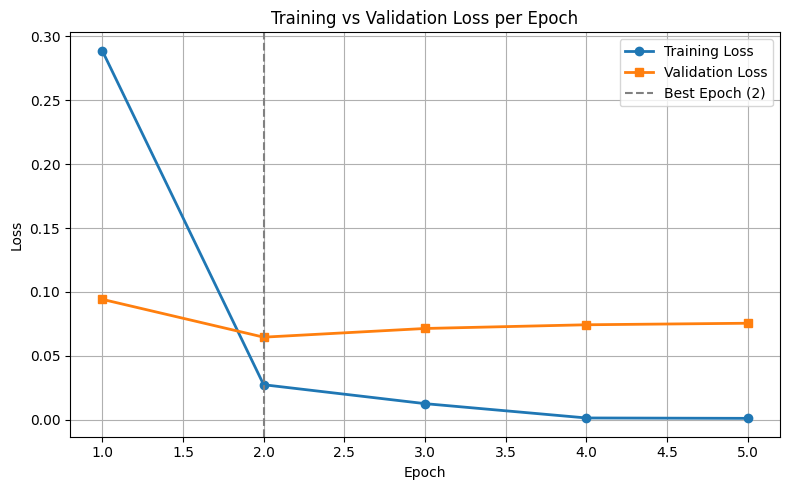

In [6]:
import matplotlib.pyplot as plt

train_loss = [0.2887, 0.0274, 0.0126, 0.0014, 0.0011]
eval_loss =  [0.0942, 0.0646, 0.0714, 0.0743, 0.0755]
epochs = list(range(1, 6))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linewidth=2)
plt.plot(epochs, eval_loss, label='Validation Loss', marker='s', linewidth=2)
plt.axvline(x=2, linestyle='--', color='gray', label='Best Epoch (2)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Even though the dataset is small, the model is is not overfitting and we have considered the model's parameters till that epoch where validation loss has reached a minimum

In [7]:
from sklearn.metrics import roc_auc_score
import torch

# Step 1: Get predictions and true labels
# Use the trained model to predict on the validation or test dataset
predictions = trainer.predict(test_dataset)

# Step 2: Get predicted probabilities
# For ROC AUC, we need the probability scores (not just the predicted labels)
pred_probs = predictions.predictions  # shape: (num_samples, num_classes)

# Step 3: Get true labels
true_labels = predictions.label_ids  # true labels

# Step 4: Calculate ROC AUC score (for binary classification)
# We need the probabilities of the positive class (class 1)
roc_auc = roc_auc_score(true_labels, pred_probs[:, 1])

# Step 5: Print ROC AUC score
print(f"ROC AUC Score: {roc_auc}")


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

ROC AUC Score: 1.0


In [ ]:
import torch
import numpy as np
import joblib

# Custom wrapper to make  Hugging Face model behave like a Scikit-learn model
class BertWrapper:
    def __init__(self, model, tokenizer, device='cpu'):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()

    def predict_proba(self, texts):
        all_probs = []
        with torch.no_grad():
            for i in range(0, len(texts), 16):  # batch size
                batch = texts[i:i+16]
                encodings = self.tokenizer(
                    batch,
                    truncation=True,
                    padding=True,
                    return_tensors='pt',
                    max_length=128
                )
                input_ids = encodings['input_ids'].to(self.device)
                attention_mask = encodings['attention_mask'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
        return np.array(all_probs).reshape(-1, 1)


In [ ]:
# Use  existing model/tokenizer from the Trainer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
wrapped_model = BertWrapper(model=model, tokenizer=tokenizer, device=device)

# Save it as a .pkl for later ensemble use
joblib.dump(wrapped_model, 'bert_model.pkl')


['bert_model.pkl']